In [101]:
from sklearn.ensemble import RandomForestClassifier
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import sys 
import os
sys.path.append(os.path.abspath("/Users/13793/Desktop/aas/stock"))
import processer as processer
import yfinance as yf
import matplotlib.pyplot as plt
import statistics
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import numpy
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [102]:
#Prepare the mixed data
stocks = pd.read_csv('C:/Users/13793/Desktop/aas/stock/Stock_with_sentiment.csv', encoding='ISO-8859-1')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks['Sentiment_Weighted'] = pd.to_numeric(stocks['Sentiment_Weighted'])
stocks['Sentiment_mean'] = pd.to_numeric(stocks['Sentiment_mean'])
stocks['Tweets'] = pd.to_numeric(stocks['Tweets'])
stocks['Tweets_mean'] = pd.to_numeric(stocks['Tweets_mean'])
stocks['Volume_Change'] = pd.to_numeric(stocks['Volume_Change'])
stocks['Percent_Change_Bin'] = pd.to_numeric(stocks['Percent_Change_Bin'])

stocks



,Ticker,Date,Sentiment_Weighted,Sentiment_mean,Tweets,Tweets_mean,Adj Close,Percent_Change,Percent_Change_Bin,Volume_Change,Volume_Change_Bin,Close,Volume,Low,High,Open
0,aal,2016-03-11,0.090909,0.090909,33,33.000000,40.697010,0.282561,1,-19.880733,0,42.470001,5701500.0,41.700001,42.500000,41.889999
1,aal,2016-03-14,0.210526,0.143576,19,25.000000,40.812004,-1.127042,0,-2.683888,0,42.590000,4568000.0,42.119999,42.700001,42.310001
2,aal,2016-03-15,0.200000,0.106539,45,25.000000,40.352036,0.474946,1,7.817069,1,42.110001,4445400.0,41.980000,42.490002,42.299999
3,aal,2016-03-16,0.341176,0.250568,85,49.666667,40.543686,-0.496327,0,24.363120,2,42.310001,4792900.0,41.590000,42.430000,41.810001
4,aal,2016-03-18,0.081967,0.230479,61,62.333333,41.626507,0.069079,1,-65.397934,0,43.439999,13746000.0,41.750000,43.529999,42.310001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,wdc,2016-06-10,0.600000,0.614035,35,58.333333,40.854412,-1.216640,0,-21.877925,0,46.849998,5876700.0,46.430000,47.759998,47.689999
2827,wdc,2016-06-13,0.594595,0.572072,37,30.000000,40.357361,0.259286,1,19.039425,1,46.279999,4591000.0,46.250000,47.490002,46.650002
2828,wdc,2016-06-14,0.710526,0.601707,38,30.333333,40.462002,-0.301729,0,-35.902362,0,46.400002,5465100.0,45.459999,47.430000,46.250000
2829,wdc,2016-06-15,0.333333,0.546151,30,35.000000,40.339916,0.345877,1,-6.151870,0,46.259998,3503000.0,46.009998,47.020000,46.400002


Show that Sentiment only is the best in Random Forest and NN can not compete with Random Forest in Classification

In [103]:
#Prepare the train/test. We do 0.5/0.5 here to reveal the growing process of the stock
stocks = stocks.sort_values(['Date', 'Ticker'])
#This is essential for Neural Networks as it is unable to treat binary classification. So we want to emphasis the sign difference
stocks['Shifted_Percent_Change'] = [numpy.sign(x) * (100 + numpy.abs(x)) for x in stocks['Percent_Change']]
model = RandomForestClassifier(random_state=1)
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)
d_test = stocks.loc[stocks['Date'] >= datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)


In [104]:
# RF with no sentiment
# Remove extra columns from train data 
X_train = d_train[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_test = d_test['Percent_Change_Bin'].values
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

model.fit(X_train, y_train)
prediction = model.predict(X_test)
d_test['Prediction'] = prediction

(670, 5) (670,)
(2161, 5) (2161,)




In [105]:
#RF with sentiment
X_train = d_train[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_train = d_train['Percent_Change_Bin'].values
X_test = d_test[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_test = d_test['Percent_Change_Bin'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

# Define random forest classifier
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

# Add predictions to test dataset 
d_test['Preds'] = preds

(670, 4) (670,)
(2161, 4) (2161,)


0.21332716335030077




In [106]:
#RF with everything
X_train = d_train[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean',"Adj Close", "Volume", "Low", "High", "Open"]].values
y_train = d_train['Percent_Change_Bin'].values
X_test = d_test[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean',"Adj Close", "Volume", "Low", "High", "Open"]].values
y_test = d_test['Percent_Change_Bin'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
predicts = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

d_test['Predicts'] = predicts

(670, 9) (670,)
(2161, 9) (2161,)


0.21332716335030077




In [108]:
#For LSTM we need some validation data
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)
d_val = d_train.loc[d_train['Date'] >= datetime.datetime(year=2016, month=4, day=12)].reset_index(drop=True)
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=12)].reset_index(drop=True)

# Remove extra columns from train data 
X_train = d_train[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_train = d_train['Shifted_Percent_Change'].values

# Remove extra solumns from val data 
X_val = d_val[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_val = d_val['Shifted_Percent_Change'].values

# Remove extra solumns from test data 
X_test = d_test[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_test = d_test['Shifted_Percent_Change'].values

#Use relu here for activation
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

#Since we already emphasis the sign difference before, it is good to use mse
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60)

Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 10230.7139 - mean_absolute_error: 101.1420 - val_loss: 10241.1172 - val_mean_absolute_error: 101.1906
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10205.2236 - mean_absolute_error: 101.0176 - val_loss: 10249.3066 - val_mean_absolute_error: 101.2311
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10210.3359 - mean_absolute_error: 101.0421 - val_loss: 10264.8896 - val_mean_absolute_error: 101.3077
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10209.0684 - mean_absolute_error: 101.0358 - val_loss: 10277.2266 - val_mean_absolute_error: 101.3680
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10202.9551 - mean_absolute_error: 101.0051 - val_loss: 10283.9199 - val_mean_absolute_error: 101.4004
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10192.6074 - mean_absolute_error: 100.9538 - val_loss: 10282.0566 - val_mean_absolute_error: 101.3908
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0

In [109]:
test_predictions = model.predict(X_test)
d_test['LSTM_Predict'] = test_predictions

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


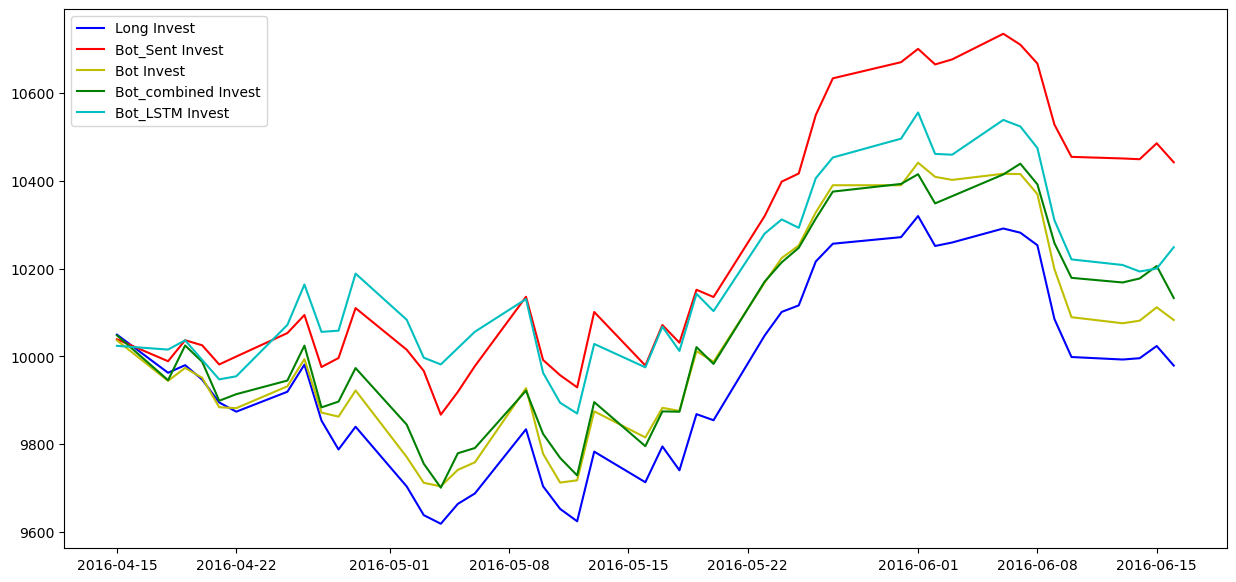

Long-Term Investment: 9979.19 ( -0.21 % )
Bot_sent Trading: 10442.44 ( 4.42 % )
Bot Trading: 10083.05 ( 0.83 % )
Bot_combined Trading: 10133.19 ( 1.33 % )
Bot_LSTM Trading: 10249.02 ( 2.49 % )


In [187]:
# Initialize starting capital to test model effectiveness
bot_capital = 10000
bot_sent_capital = 10000
bot_combined_capital = 10000
bot_LSTM_capital = 10000
long_capital = 10000

# Add capital as first data points
bots = [bot_capital]
bots_sent = [bot_sent_capital]
bots_combined = [bot_combined_capital]
bots_LSTM = [bot_LSTM_capital]
longs = [long_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()
# For each date, we have the following technique, we purchase double for stock with strong positive sentiment, purchase single for stock with light positive sentiment, and don't purchase any negative sentiment
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]
    
    # Calculate profit from investing equal parts to all tickers in timeframe
    long_capital = long_capital + ((long_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the no_sentiment bot to determine what stocks to invest in 
    temp = temp[temp['Prediction']>0]
    temp1 = temp[temp['Prediction']>1]
    bot_capital = bot_capital + (bot_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()
    
    # Calculate profit from using the sentiment bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['Preds']>0]
    temp1 = temp[temp['Preds']>1]
    bot_sent_capital = bot_sent_capital + (bot_sent_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_sent_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()
    
    # Calculate profit from using the mixed bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['Predicts']>0]
    temp1 = temp[temp['Predicts']>1]
    bot_combined_capital = bot_combined_capital + (bot_combined_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_combined_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()
    
    # Calculate profit from using the LSTM bot to determine what stocks to invest in 
    #Convert LSTM prediction into Bin
    k=(2-stocks['Percent_Change'].mean())/stocks['Percent_Change'].std()
    t = (k*statistics.stdev(d_test['LSTM_Predict']))+d_test['LSTM_Predict'].mean()
    d_test['LSTM_Predict_Bin'] = pd.cut(d_test['LSTM_Predict'], [-10000, 0, t, 10000], labels=[0, 1, 2])
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['LSTM_Predict_Bin']>0]
    temp1 = temp[temp['LSTM_Predict_Bin']>1]
    bot_LSTM_capital = bot_LSTM_capital + (bot_LSTM_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_LSTM_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()
    
    # Keep track of the account totals ove time 
    longs.append(long_capital)
    bots.append(bot_capital)
    bots_sent.append(bot_sent_capital)
    bots_combined.append(bot_combined_capital)
    bots_LSTM.append(bot_LSTM_capital)

# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.plot(dates, longs[1:], c='b', label='Long Invest')
plt.plot(dates, bots_sent[1:], c='r', label='Bot_Sent Invest')
plt.plot(dates, bots[1:], c='y', label='Bot Invest')
plt.plot(dates, bots_combined[1:], c='g', label='Bot_combined Invest')
plt.plot(dates, bots_LSTM[1:], c='c', label='Bot_LSTM Invest')
plt.legend()
plt.show()

# Show the return from each account over time 
print('Long-Term Investment:', round(longs[-1],2), '(', round((longs[-1]-longs[0])/longs[0]*100,2), '% )')
print('Bot_sent Trading:', round(bots_sent[-1],2), '(', round((bots_sent[-1]-bots_sent[0])/bots_sent[0]*100,2), '% )')
print('Bot Trading:', round(bots[-1],2), '(', round((bots[-1]-bots[0])/bots[0]*100,2), '% )')
print('Bot_combined Trading:', round(bots_combined[-1],2), '(', round((bots_combined[-1]-bots_combined[0])/bots_combined[0]*100,2), '% )')
print('Bot_LSTM Trading:', round(bots_LSTM[-1],2), '(', round((bots_LSTM[-1]-bots_LSTM[0])/bots_LSTM[0]*100,2), '% )')

The reason why LSTM is even worse than random forest is that our techinique is based on binary classifacation.

Show that sentiment only is the best in NN as well as in RF

In [188]:
#For no_sent model
# Remove extra columns from train data 
X_train = d_train[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_train = d_train['Shifted_Percent_Change'].values

# Remove extra solumns from val data 
X_val = d_val[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_val = d_val['Shifted_Percent_Change'].values

# Remove extra solumns from test data 
X_test = d_test[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_test = d_test['Shifted_Percent_Change'].values
y_test = d_test['Shifted_Percent_Change'].values
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60)

Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 10205.8945 - mean_absolute_error: 101.0194 - val_loss: 10221.1260 - val_mean_absolute_error: 101.0912
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10222.2432 - mean_absolute_error: 101.1004 - val_loss: 10230.1104 - val_mean_absolute_error: 101.1359
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10199.4902 - mean_absolute_error: 100.9885 - val_loss: 10231.2520 - val_mean_absolute_error: 101.1415
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10227.4639 - mean_absolute_error: 101.1259 - val_loss: 10237.1562 - val_mean_absolute_error: 101.1707
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10210.1182 - mean_absolute_error: 101.0408 - val_loss: 10236.5264 - val_mean_absolute_error: 101.1675
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10228.0137 - mean_absolute_error: 101.1292 - val_loss: 10240.5596 - val_mean_absolute_error: 101.1875
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0

In [189]:
test_predictions_nosent = model.predict(X_test)
d_test['LSTM_Predict_nosent'] = test_predictions_nosent

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [190]:
#For mixed model
# Remove extra columns from train data 
X_train = d_train[["Adj Close", "Volume", "Low", "High", "Open",'Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_train = d_train['Shifted_Percent_Change'].values

# Remove extra solumns from test data 
X_val = d_val[["Adj Close", "Volume", "Low", "High", "Open",'Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_val = d_val['Shifted_Percent_Change'].values

# Remove extra solumns from test data 
X_test = d_test[["Adj Close", "Volume", "Low", "High", "Open",'Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_test = d_test['Shifted_Percent_Change'].values
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=60)

Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 10208.8789 - mean_absolute_error: 101.0337 - val_loss: 10209.7217 - val_mean_absolute_error: 101.0347
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10215.2910 - mean_absolute_error: 101.0650 - val_loss: 10220.1992 - val_mean_absolute_error: 101.0870
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10204.0557 - mean_absolute_error: 101.0096 - val_loss: 10244.7178 - val_mean_absolute_error: 101.2081
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10202.6943 - mean_absolute_error: 101.0034 - val_loss: 10248.9375 - val_mean_absolute_error: 101.2277
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10200.6094 - mean_absolute_error: 100.9926 - val_loss: 10262.8779 - val_mean_absolute_error: 101.2957
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10199.2607 - mean_absolute_error: 100.9823 - val_loss: 10233.8574 - val_mean_absolute_error: 101.1433
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━

In [191]:
test_predictions_mixed = model.predict(X_test)
d_test['LSTM_Predict_mixed'] = test_predictions_mixed

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


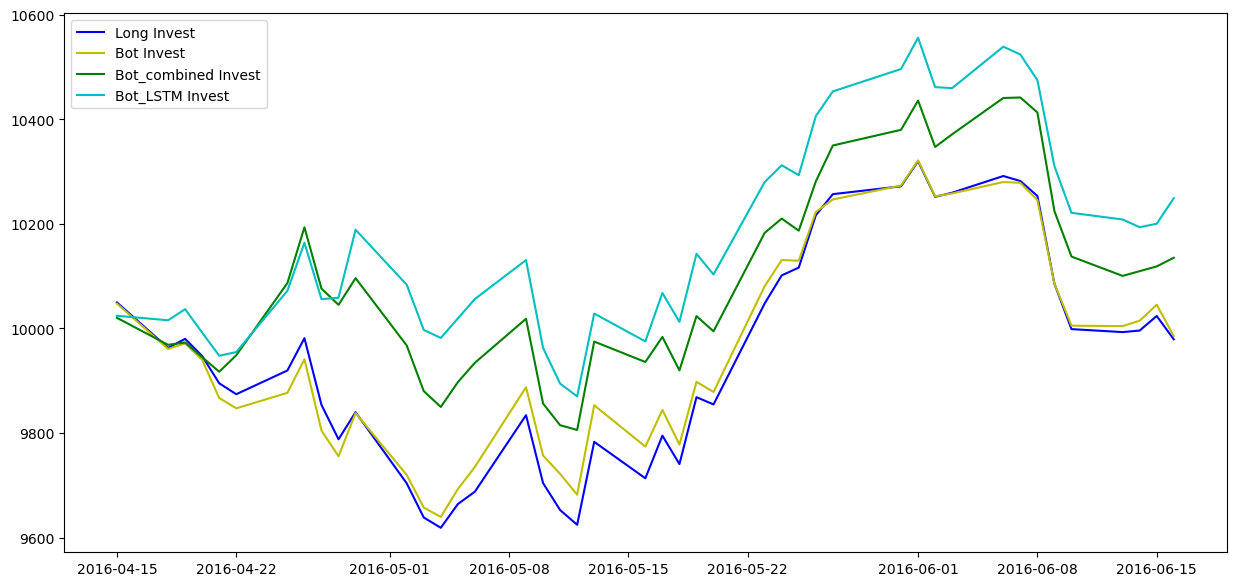

Long-Term Investment: 9979.19 ( -0.21 % )
Bot_LSTM_NOSENT Trading: 9985.53 ( -0.14 % )
Bot_LSTM_combined Trading: 10135.22 ( 1.35 % )
Bot_LSTM Trading: 10249.02 ( 2.49 % )


In [194]:
#Same technique as before
bot_LSTM_mixed_capital = 10000
bot_LSTM_nosent_capital = 10000
bot_LSTM_capital = 10000
long_capital = 10000

# Add capital as first data points
bots = [bot_LSTM_nosent_capital]
bots_combined = [bot_LSTM_mixed_capital]
bots_LSTM = [bot_LSTM_capital]
longs = [long_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()
# For each date
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]
    # We want to convert the LSTM prediction into bins too
    k=(2-stocks['Percent_Change'].mean())/stocks['Percent_Change'].std()

    # Calculate profit from investing equal parts to all tickers in timeframe
    long_capital = long_capital + ((long_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the Sentiment bot to determine what stocks to invest in 
    t = (k*statistics.stdev(d_test['LSTM_Predict']))+d_test['LSTM_Predict'].mean()
    d_test['LSTM_Predict_Bin'] = pd.cut(d_test['LSTM_Predict'], [-10000, 0, t, 10000], labels=[0, 1, 2])
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['LSTM_Predict_Bin']>0]
    temp1 = temp[temp['LSTM_Predict_Bin']>1]
    bot_LSTM_capital = bot_LSTM_capital + (bot_LSTM_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_LSTM_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()
    
    # Calculate profit from using the No_sent bot to determine what stocks to invest in 
    t = (k*statistics.stdev(d_test['LSTM_Predict_nosent']))+d_test['LSTM_Predict_nosent'].mean()
    d_test['LSTM_Predict_nosent_Bin'] = pd.cut(d_test['LSTM_Predict_nosent'], [-10000, 0, t, 10000], labels=[0, 1, 2])
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['LSTM_Predict_nosent_Bin']>0]
    temp1 = temp[temp['LSTM_Predict_nosent_Bin']>1]
    bot_LSTM_nosent_capital = bot_LSTM_nosent_capital + (bot_LSTM_nosent_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_LSTM_nosent_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()

    # Calculate profit from using the Mixed bot to determine what stocks to invest in 
    t = (k*statistics.stdev(d_test['LSTM_Predict_mixed']))+d_test['LSTM_Predict_mixed'].mean()
    d_test['LSTM_Predict_mixed_Bin'] = pd.cut(d_test['LSTM_Predict_mixed'], [-10000, 0, t, 10000], labels=[0, 1, 2])
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['LSTM_Predict_mixed_Bin']>0]
    temp1 = temp[temp['LSTM_Predict_mixed_Bin']>1]
    bot_LSTM_mixed_capital = bot_LSTM_mixed_capital + (bot_LSTM_mixed_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_LSTM_mixed_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum()

    # Keep track of the account totals ove time 
    longs.append(long_capital)
    bots.append(bot_LSTM_nosent_capital)
    bots_combined.append(bot_LSTM_mixed_capital)
    bots_LSTM.append(bot_LSTM_capital) 
    
# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.plot(dates, longs[1:], c='b', label='Long Invest')
plt.plot(dates, bots[1:], c='y', label='Bot Invest')
plt.plot(dates, bots_combined[1:], c='g', label='Bot_combined Invest')
plt.plot(dates, bots_LSTM[1:], c='c', label='Bot_LSTM Invest')
plt.legend()
plt.show()

# Show the return from each account over time 
print('Long-Term Investment:', round(longs[-1],2), '(', round((longs[-1]-longs[0])/longs[0]*100,2), '% )')
print('Bot_LSTM_NOSENT Trading:', round(bots[-1],2), '(', round((bots[-1]-bots[0])/bots[0]*100,2), '% )')
print('Bot_LSTM_combined Trading:', round(bots_combined[-1],2), '(', round((bots_combined[-1]-bots_combined[0])/bots_combined[0]*100,2), '% )')
print('Bot_LSTM Trading:', round(bots_LSTM[-1],2), '(', round((bots_LSTM[-1]-bots_LSTM[0])/bots_LSTM[0]*100,2), '% )')

It is good to see that Sentiment actually works, but the fact that the no_sent technique is not good reveals that in this specific trading technique, neural networks is not a good option.

The reason is easy to follow: in most neural networks, the accuracy relies on net-difference, while our trading technique depending on binary.

Future direction: Design another trading techique targeting on NN (remember the log1/log2 feature on the previous file?).

Show that Random Forest is the best classifier

In [242]:
#Re-split the data since we don't need validation
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)
d_test = stocks.loc[stocks['Date'] >= datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Remove extra columns from train data 
X_train = d_train[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_test = d_test['Percent_Change_Bin'].values

In [243]:
## make the knn model object
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(5))])

## "fit" the model object
knn_pipe.fit(X_train,
           y_train)
knn_predict = knn_pipe.predict(X_test)
d_test['knn_predict'] = knn_predict

In [244]:
## make the log_regression model object
log_reg = LogisticRegression(penalty=None)

## fit the model
log_reg.fit(X_train,
            y_train)
log_predict = log_reg.predict(X_test)
d_test['log_predict'] = log_predict

c:\Users\13793\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [248]:
# Define random forest classifier
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
NetPred = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

# Add predictions to test dataset 
d_test['RF_Predict'] = NetPred

0.21332716335030077




In [246]:
#Train XG_boost to find the best parameter
xgb_reg = xgboost.XGBRegressor()
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": np.arange(1,100,5),
              "learning_rate": [0.01, 0.1, 1]}
search = GridSearchCV(xgb_reg, param_grid, cv=5).fit(X_train, y_train)
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 11}


In [247]:
#Use the best model
xgb_reg = xgboost.XGBRegressor(learning_rate=0.1,
                                   max_depth=4,
                                   n_estimators=11)
xgb_reg.fit(X_train, y_train)
XG_predict = xgb_reg.predict(X_test)
d_test['XG_Predict'] = (XG_predict*2).round()

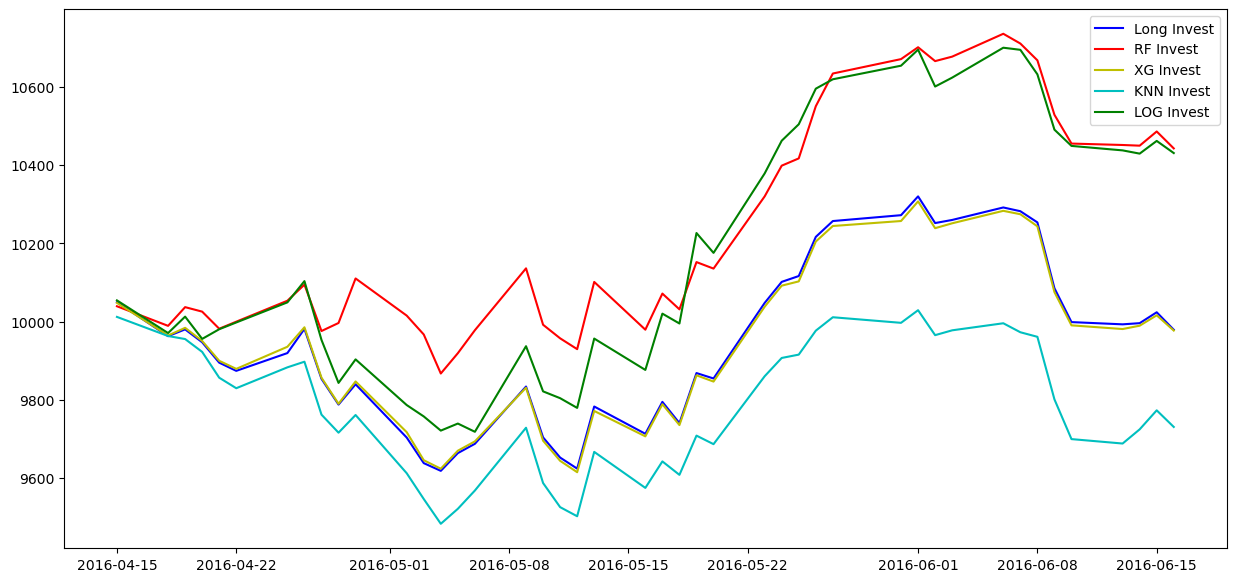

Long-Term Investment: 9979.19 ( -0.21 % )
RF Trading: 10442.44 ( 4.42 % )
XG Trading: 9977.11 ( -0.23 % )
KNN Trading: 9730.83 ( -2.69 % )
LOG Trading: 10430.53 ( 4.31 % )


In [249]:
# Initialize starting capital to test model effectiveness
bot_KNN_capital = 10000
bot_RF_capital = 10000
bot_log_capital = 10000
bot_XG_capital = 10000
long_capital = 10000

# Add capital as first data points
bot_KNN = [bot_KNN_capital]
bot_RF = [bot_RF_capital]
bot_log = [bot_log_capital]
bot_XG = [bot_XG_capital]
longs = [long_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()
# For each date
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]
    
    # Calculate profit from investing equal parts to all tickers in timeframe
    long_capital = long_capital + ((long_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the XG bot to determine what stocks to invest in 
    temp = temp[temp['XG_Predict']>0]
    temp1 = temp[temp['XG_Predict']>1]
    bot_XG_capital = bot_XG_capital + (bot_XG_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_XG_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum() 
    # Calculate profit from using the RF bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['RF_Predict']>0]
    temp1 = temp[temp['RF_Predict']>1]
    bot_RF_capital = bot_RF_capital + (bot_RF_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_RF_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum() 
        # Calculate profit from using the KNN bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['knn_predict']>0]
    temp1 = temp[temp['knn_predict']>1]
    bot_KNN_capital = bot_KNN_capital + (bot_KNN_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_KNN_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum() 
        # Calculate profit from using the LOG bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['log_predict']>0]
    temp1 = temp[temp['log_predict']>1]
    bot_log_capital = bot_log_capital + (bot_log_capital/(len(temp)+len(temp1)) * (temp['Percent_Change']/100)).sum() + (bot_log_capital/(len(temp)+len(temp1)) * (temp1['Percent_Change']/100)).sum() 
    # Keep track of the account totals ove time 
    longs.append(long_capital)
    bot_KNN.append(bot_KNN_capital)
    bot_RF.append(bot_RF_capital)
    bot_log.append(bot_log_capital)
    bot_XG.append(bot_XG_capital)   
   
# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.plot(dates, longs[1:], c='b', label='Long Invest')
plt.plot(dates, bot_RF[1:], c='r', label='RF Invest')
plt.plot(dates, bot_XG[1:], c='y', label='XG Invest')
plt.plot(dates, bot_KNN[1:], c='c', label='KNN Invest')
plt.plot(dates, bot_log[1:], c='g', label='LOG Invest')

plt.legend()
plt.show()

# Show the return from each account over time 
print('Long-Term Investment:', round(longs[-1],2), '(', round((longs[-1]-longs[0])/longs[0]*100,2), '% )')
print('RF Trading:', round(bot_RF[-1],2), '(', round((bot_RF[-1]-bot_RF[0])/bot_RF[0]*100,2), '% )')
print('XG Trading:', round(bot_XG[-1],2), '(', round((bot_XG[-1]-bot_XG[0])/bot_XG[0]*100,2), '% )')
print('KNN Trading:', round(bot_KNN[-1],2), '(', round((bot_KNN[-1]-bot_KNN[0])/bot_KNN[0]*100,2), '% )')
print('LOG Trading:', round(bot_log[-1],2), '(', round((bot_log[-1]-bot_log[0])/bot_log[0]*100,2), '% )')


This validate that in the first section it is good to use RF

Future direction:

1. We hasn't talk about volume change. Volume change is a mid-factor that interreact with stock price and also influence (even more heavily) by sentiment

2. We expect better result for LSTM. LSTM is not good for binary classification. We do binary classification to fit in the bootcamp course, and we demonstrate our ability for NN in the previous project.

3. We could add the sentiment strenghth as a factor. That will: possibly cause overfitting based on the current training model; more accurately predict the (0,1,2) Bin so that we can versatilize our trading technique.